In [3]:
import pandas as pd
from tqdm import tqdm
from prophet import Prophet
from multiprocessing import Pool
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed

In [4]:




df = pd.read_csv("../../data/Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
df.head()


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28
0,274772,0,Northeast Dallas,Neighborhood,TX,TX,Dallas,Dallas-Fort Worth-Arlington,Dallas County,152015.0,...,372546.0,377913.0,383433.0,392937.0,401887.0,408992.0,412395.0,415109.0,420563.0,429379.0
1,112345,1,Maryvale,Neighborhood,AZ,AZ,Phoenix,Phoenix-Mesa-Scottsdale,Maricopa County,82669.0,...,248263.0,255152.0,262240.0,267642.0,270996.0,275557.0,279579.0,285261.0,289341.0,295296.0
2,192689,2,Paradise,Neighborhood,NV,NV,Las Vegas,Las Vegas-Henderson-Paradise,Clark County,151457.0,...,310939.0,320619.0,330959.0,339154.0,346139.0,352468.0,359251.0,365178.0,374076.0,383261.0
3,270958,3,Upper West Side,Neighborhood,NY,NY,New York,New York-Newark-Jersey City,New York County,393147.0,...,1375461.0,1374186.0,1375304.0,1386688.0,1398675.0,1405719.0,1405824.0,1405774.0,1413542.0,1426351.0
4,118208,4,South Los Angeles,Neighborhood,CA,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,154308.0,...,615456.0,626841.0,642600.0,654703.0,665063.0,667496.0,669307.0,672481.0,678038.0,686387.0


In [5]:
print(len(df))
print(df.columns)

16424
Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '2000-01-31',
       ...
       '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
       '2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31', '2022-02-28'],
      dtype='object', length=275)


In [6]:
'''
Let's do the following: 
Train an autoregressive model on this data and predict the housing price growth for the next 5 years. 

'''

"\nLet's do the following: \nTrain an autoregressive model on this data and predict the housing price growth for the next 5 years. \n\n"

In [7]:
# let's transform this data
nd_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName']
date_cols = [x for x in df.columns if x not in nd_cols]



In [8]:
df = df[df.State=='TX']
df = df[df.Metro.isin(['Austin-Round Rock', 'San Antonio-New Braunfels'])]

df.head()


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28
423,271427,438,Highland Hills,Neighborhood,TX,TX,San Antonio,San Antonio-New Braunfels,Bexar County,71679.0,...,152787.0,156566.0,160125.0,163985.0,165858.0,168495.0,170380.0,173292.0,176090.0,178710.0
431,274685,446,North Austin,Neighborhood,TX,TX,Austin,Austin-Round Rock,Travis County,124178.0,...,451714.0,474479.0,492130.0,504682.0,508334.0,510812.0,512516.0,523041.0,534260.0,549714.0
445,275097,461,Prospect Hill,Neighborhood,TX,TX,San Antonio,San Antonio-New Braunfels,Bexar County,49735.0,...,119524.0,122651.0,126349.0,129219.0,133464.0,135775.0,137792.0,138911.0,142324.0,145547.0
569,275005,590,People Active in Community Effort,Neighborhood,TX,TX,San Antonio,San Antonio-New Braunfels,Bexar County,84186.0,...,181224.0,185257.0,187771.0,191215.0,192114.0,194463.0,196430.0,200001.0,203214.0,206369.0
713,271622,743,Vance Jackson,Neighborhood,TX,TX,San Antonio,San Antonio-New Braunfels,Bexar County,126493.0,...,258577.0,264509.0,269746.0,275276.0,279385.0,284381.0,289102.0,294482.0,299057.0,302460.0


In [20]:
df = df.dropna(how = 'any')
print(len(df))

348


In [24]:
# what we want to do is create a list of data
# https://neuralprophet.com/html/global_modeling.html


df_list = []
df_dict = {}

for r in tqdm(df.to_dict(orient = 'row')):
    rid = r['RegionID']
    
    d = pd.DataFrame(data = {"ds": date_cols, "y": [r[d] for d in date_cols]})
    df_dict[rid] = d
    

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_52/2369019305.py:8: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  for r in tqdm(df.to_dict(orient = 'row')):

100%|██████████| 348/348 [00:00<00:00, 1881.91it/s]


In [47]:
n = NeuralProphet(n_lags = 24, n_forecasts=36)
df_train, df_test = n.split_df(df_dict, valid_p = 0.33, local_split = True)

INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 90.977% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 90.977% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 90.977% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 90.977% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 90.977% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 90.977% of the data.
INFO - (NP.df_utils._infer

In [49]:
m = NeuralProphet(n_lags = 24, n_forecasts = 36)
metrics = m.fit(df_train, freq = 'M')

INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 90.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 90.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 90.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 90.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 90.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 90.857%

In [50]:
future[275097].tail()

,ds,y
20,2021-11-30,137792.0
21,2021-12-31,138911.0
22,2022-01-31,142324.0
23,2022-02-28,145547.0
24,2022-03-31,None


In [ ]:
future = m.make_future_dataframe(df_test, n_historic_predictions = True, periods = 120)
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 90.435% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 36.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.9/site-packages/neuralprophet/forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 90.435% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 36.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.9/site-packages/neuralprophet/forecaster.py:2060: FutureWa

In [35]:
list(df_test.keys())[:10]

[271427,
 274685,
 275097,
 275005,
 271622,
 271391,
 275057,
 272738,
 271635,
 416968]

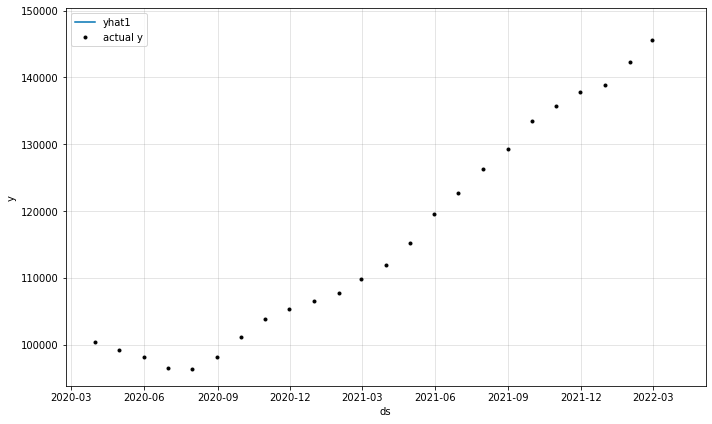

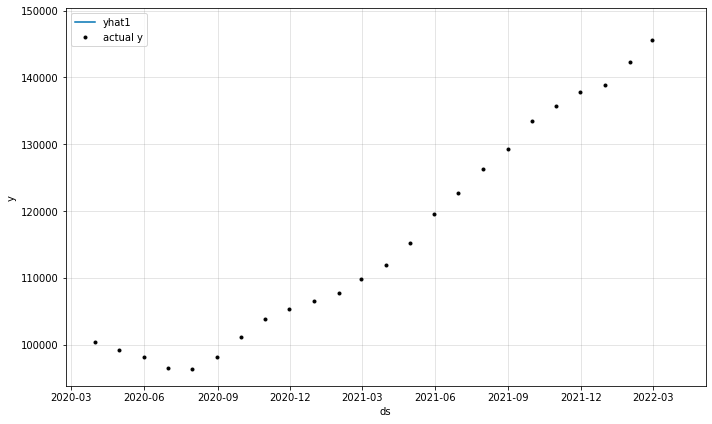

In [36]:
m.plot(forecast[275097])


In [37]:
forecast[275097].head()

,ds,y,yhat1,residual1,ar1,trend,season_yearly
0,2020-03-31,100410.0,None,NaN,None,None,None
1,2020-04-30,99144.0,None,NaN,None,None,None
2,2020-05-31,98088.0,None,NaN,None,None,None
3,2020-06-30,96494.0,None,NaN,None,None,None
4,2020-07-31,96403.0,None,NaN,None,None,None
